In [18]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui
from sklearn.preprocessing import StandardScaler 
import compress_pickle

In [2]:
def selectTrainTestSet(rhr, info,train_days=100,test_days=14):
    if info['covid_test_date']:
        dates_s = rhr.loc[(rhr.index < info['covid_test_date'] - pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique()
        dates_e = list(rhr.loc[(rhr.index > info['covid_test_date'] + pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique())
    else:
        dates_s = rhr.index.floor('1D').unique()
        dates_e = []

    dates_s=dates_s.insert(0,rhr.index[0])
    dates_e.append(rhr.index[-1])

    s = min(train_days, len(dates_s)-1)
    e = -min(max(0,train_days-s), len(dates_e)-1)
    train = rhr.loc[(rhr.index < dates_s[s]) | (rhr.index > dates_e[e])]
    test = rhr.loc[(rhr.index >= dates_s[s]) & (rhr.index <= dates_e[e])]
    
    return train, test


def preprocessing(train, test=None,force=True):
    if (not force) and os.path.isfile(f'ali/an_data/preprocess.pkl.lz4'):
        scaler = compress_pickle.load(f'ali/an_data/preprocess.pkl.lz4')
    else:
        scaler = StandardScaler()
        scaler = scaler.fit(train[['heartrate']])
        compress_pickle.dump(scaler, f'ali/an_data/preprocess.pkl.lz4')

    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    if test is not None:
        test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
    return train, test

In [54]:
i

875

In [11]:
resolution='1T'
alltest=pd.DataFrame()
alltrain=pd.DataFrame()

dirs=os.listdir('output/my')
for i,id in enumerate(dirs):

    if not "P" in id :continue
        
    print(f'{i/len(dirs)*100:.0f}%',end='\r')
    hr,step,rhr,info=ali.methods.load(id)
    if len(rhr)==0:continue
#     if info['covid_test_date']:
    rhr1=rhr.resample(resolution).mean().dropna()
    rhr1['id']=id
    train,test=selectTrainTestSet(rhr1,info,train_days=30)
    alltrain=pd.concat([alltrain,train])
    alltest=pd.concat([alltest,test])
    


In [13]:
alltrain=alltrain.reset_index().set_index(['id','datetime'])
alltrain.to_hdf('all-train.h5','train')

alltest=alltest.reset_index().set_index(['id','datetime'])
alltest.to_hdf('all-test.h5','test')

In [24]:
alltrainp,alltestp=preprocessing(alltrain,alltest,force=True)
alltrainp.to_hdf('all-trainp.h5','trainp')
alltestp.to_hdf('all-testp.h5','testp')

In [25]:
alltrainp=pd.read_hdf('all-trainp.h5',key='trainp')
alltestp=pd.read_hdf('all-testp.h5',key='testp')


In [4]:
def create_sequences(data, resolution, seg):

    dates = data.loc[data.index.hour < 7].dropna().resample('1D').count()
    min_acceptable_count = dates.loc[dates['heartrate'] > 0].mean().values[0]/4
#     data['date'] = data.index.floor('1D')
#     data['time'] = data.index.time
#     day_time = data.set_index(['time', 'date']).unstack(level=0).droplevel(0, axis=1).interpolate(limit_direction='both', axis=1)
    out=[]
    for w in dates.rolling(window=f'{seg}D', closed='right'):
#         if len(w)==seg and w.sum().values[0]>min_acceptable_count*seg:
#         if len(w)==seg:
#             display(w.values>min_acceptable_count)
#             break
        if len(w)==seg and np.all(w.values>min_acceptable_count):
            res = day_time.reindex(w.index).interpolate(limit_direction='both', axis=0).values
            out.append(np.reshape(res, (res.shape[0]*res.shape[1],1)))
#             out.append(res)
    if len(out)==0:
        return out
    return np.stack(out)

In [5]:
seg=3
seqs=[]
ids=allp.index.get_level_values(0)
allp2=allp.reset_index().set_index(['datetime'])
allp2['date'] = allp2.index.floor('1D')
allp2['time'] = allp2.index.time
# for i,p in enumerate(ids):
#     print(f'{i/len(ids)*100:.0f}%',end='\r')
#     seqs.append(create_sequences(allp.loc[p],resolution=resolution,seg=seg))



In [6]:
day_time = allp2.set_index(['id','time', 'date']).unstack(level=1).droplevel(0, axis=1)
# .interpolate(limit_direction='both', axis=1)

<AxesSubplot:>

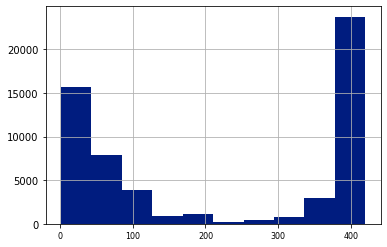

In [7]:
day_time_info=day_time.notnull().sum(axis=1)
day_time_info.hist()
# day_time_info.quantile (.6)
# day_time_info>300

In [8]:

day_time2=day_time.loc[day_time.notnull().sum(axis=1)>200]
ids=day_time2.index.get_level_values(0)
out=[]
day_time2 = day_time2.interpolate(limit_direction='both', axis=1)

n=0
shape=None
for id in ids:
  for w in day_time2.loc[id].rolling(window=f'{seg}D', closed='right'): 
    if len(w)==seg:
        n+=1
        shape=w.values.shape
#         display(w)
#         print(w.notnull().sum(axis=1))


In [31]:
out=np.zeros(shape=(n,shape[0]*shape[1],1))
i=0
for id in ids:
  for w in day_time2.loc[id].rolling(window=f'{seg}D', closed='right'): 
    if len(w)==seg:
        out[i,:,:]=(np.reshape(w.values, (shape[0]*shape[1],1)))

In [34]:
x_train=out

In [8]:
x_train=np.stack(out)

In [9]:
del out

In [35]:
x_train.shape

(939871, 1260, 1)

In [36]:
def createAutoEncoderModel(shape):
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model


In [37]:
model = createAutoEncoderModel(x_train.shape)

model.summary()
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)
model.save(f'ali/an_data/model-all-{seg}.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 630, 32)           256       
                                                                 
 dropout (Dropout)           (None, 630, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 315, 16)           3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 630, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 630, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1260, 32)         3616      
 ranspose)                                              

In [ ]:
x_train_pred = model.predict(x_train)


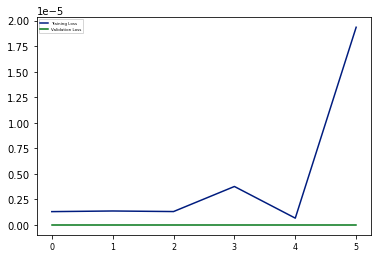

MemoryError: Unable to allocate 4.41 GiB for an array with shape (939871, 1260, 1) and data type float32

In [40]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [39]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

fig, ax = plt.subplots()
# test.plot(legend=False, ax=ax)
# plt.show()

# Create sequences from test values.
x_test = create_sequences(testp, seg=seg, resolution=resolution)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


NameError: name 'train_mae_loss' is not defined

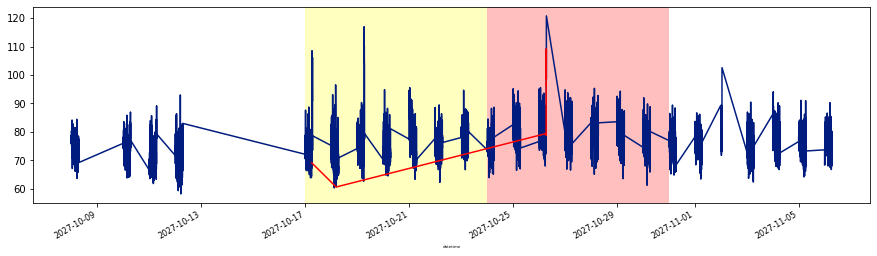

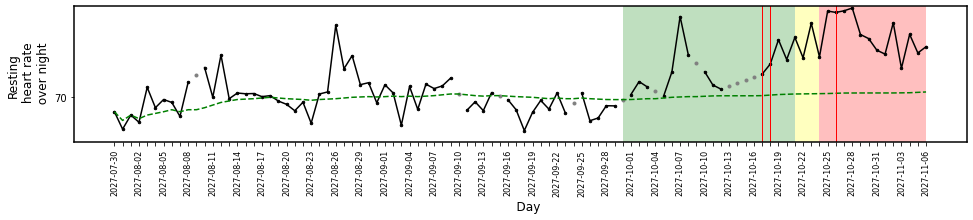

                      heartrate
datetime                       
2027-10-17 06:13:00   69.111111
2027-10-18 04:47:00   60.636364
2027-10-26 06:44:00   79.428571
2027-10-26 06:45:00   78.800000
2027-10-26 06:46:00   81.666667
2027-10-26 06:47:00   82.166667
2027-10-26 06:48:00   97.250000
2027-10-26 06:49:00   96.500000
2027-10-26 06:53:00  109.200000
2027-10-26 06:55:00   98.555556


In [8]:
df_subset = test.iloc[np.where(anomalies)]
fig, ax = plt.subplots()
fig.set_figwidth(15)

test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")

if(info['covid_test_date']!=None):
        plt.axvspan(info['covid_test_date'], min(test.index[-1], info['covid_test_date']+pd.to_timedelta('7d')), facecolor='red', alpha=0.25, label='Covid')
        plt.axvspan(info['covid_test_date'], max(test.index[1], info['covid_test_date']-pd.to_timedelta('7d')), facecolor='yellow', alpha=0.25, label='Covid')
plt.show()



dates = test.iloc[np.where(anomalies)].resample('1D').count().fillna(0).rename(columns={'heartrate': 'count'})

dates['alarm'] = (dates['count'] > 0)*2
# return dates
ali.ui.plot(rhr,alerts=dates,info=info,show=True)
print(test.iloc[np.where(anomalies)])